- Written on 7 September 2018 by Raunak
- The input trajectories to this file need to have `laneNum` as one of the attributes of the dictionary containing the actual data in the traj_lab_dict data structure

In [1]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import gaussian_kde
from scipy.stats import entropy

import hgail.misc.utils

import utils
import visualize_utils

from copy import deepcopy

In [2]:
def filename2label(fn):
    s = fn.find('-') + 1
    e = fn.find('.')
    return fn[s:e]

In [3]:
filenames = [i for i in utils.NGSIM_FILENAME_TO_ID.keys() if '101' in i]

# --------Load Expert Data----------------------

In [4]:
expert_filepath = '../../data/trajectories/ngsim.h5'

# Use this one if you need lane information
#expert_filepath = '../../data/trajectories/ngsim_addLaneID.h5'

In [5]:
# Load only the 0750-0805 timeperiod because that is the default filename
# in the utils.load_data

# Run a cell later to get the feature names
expert = dict()
expert = utils.load_data(expert_filepath, min_length=250, \
                         normalize_data=False, clip_std_multiple=10.)

In [ ]:
# Detective work on the expert stuff loaded in using utils.load_data
print(expert['0750am-0805am']['observations'].shape)
expertvels = expert['0750am-0805am']['observations'][:,2]
#print(expertvels.shape)
#plt.hist(expertvels,normed=True)

In [ ]:
#expertTimegaps = expert['0750am-0805am']['observations'][:,observation_indexes['timegap']]
#print(expertTimegaps.shape)
#print(expertTimegaps.mean())

In [6]:
x, names = utils.load_x_feature_names(
    expert_filepath, 'trajdata_i101_trajectories-0750am-0805am.txt')

In [7]:
observation_indexes = dict([(names[i], i) for i in range(len(names))])
print(names)
del(x)

['relative_offset' 'relative_heading' 'velocity' 'length' 'width'
 'lane_curvature' 'markerdist_left' 'markerdist_right' 'accel' 'jerk'
 'turn_rate_global' 'angular_rate_global' 'turn_rate_frenet'
 'angular_rate_frenet' 'timegap' 'timegap_is_avail' 'time_to_collision'
 'time_to_collision_is_avail' 'is_colliding' 'out_of_lane'
 'negative_velocity' 'distance_road_edge_left' 'distance_road_edge_right'
 'lidar_1' 'lidar_2' 'lidar_3' 'lidar_4' 'lidar_5' 'lidar_6' 'lidar_7'
 'lidar_8' 'lidar_9' 'lidar_10' 'lidar_11' 'lidar_12' 'lidar_13' 'lidar_14'
 'lidar_15' 'lidar_16' 'lidar_17' 'lidar_18' 'lidar_19' 'lidar_20'
 'rangerate_lidar_1' 'rangerate_lidar_2' 'rangerate_lidar_3'
 'rangerate_lidar_4' 'rangerate_lidar_5' 'rangerate_lidar_6'
 'rangerate_lidar_7' 'rangerate_lidar_8' 'rangerate_lidar_9'
 'rangerate_lidar_10' 'rangerate_lidar_11' 'rangerate_lidar_12'
 'rangerate_lidar_13' 'rangerate_lidar_14' 'rangerate_lidar_15'
 'rangerate_lidar_16' 'rangerate_lidar_17' 'rangerate_lidar_18'
 'rangera

In [ ]:
# Detective work on the expert stuff loaded in through 
# load_x_feature_names
#print(names)
print(type(x))
print(x.shape) # The shape obtained from utils.load_x_feature_names
print(x[0][2200][0])
print(names)
print(observation_indexes['is_colliding'])
print(observation_indexes['timegap'])
print(x[0,100:500:25,14])
plt.plot(x[1000,:,14])

In [ ]:
# Suppress scientific painful notation in printing
np.set_printoptions(suppress=True)
#print(names)
#print(x[2000,271,:])
print(x[:,:,0].shape)

In [ ]:
# Copied over from emergent metrics code. The function to calculate emergent stuff
def calc_offroad(traj):
    return float(len(traj['observations'][:,observation_indexes['out_of_lane']][
        np.where(np.isclose(traj['observations'][:,observation_indexes['out_of_lane']],1))
    ]))/ float(len(traj['observations']))

# in case we want to use a different threshold for whatever reason
def calc_offroad_manual(traj, thresh = -1.0): 
    num_offroad = float(len(traj['observations'][:,0][
        np.where(np.minimum(
            traj['observations'][:,observation_indexes['distance_road_edge_left']], \
            traj['observations'][:,observation_indexes['distance_road_edge_right']]) <= thresh)
        ]))
    return num_offroad / float(len(traj['observations']))

def calc_hard_brake(traj, thresh = -3.0):
    #traj should be unnormalized
    return float(len(traj['observations'][:,observation_indexes['accel']][np.where(\
                traj['observations'][:,observation_indexes['accel']] <= thresh)])) \
                / float(len(traj['actions']))

def calc_collisions(traj, expert=True, H=200, nveh=100, verbose = True):
    if expert:
        if verbose:
            print("shape = ",traj['observations'].shape)
            print("shape of is_colliding column = ",\
                  traj['observations'][:,observation_indexes['is_colliding']].shape)
            print("len(traj[obs]) = ",len(traj['observations']))
        return float(len(traj['observations'][:,observation_indexes['is_colliding']][
            np.where(np.isclose(traj['observations'][:,observation_indexes['is_colliding']],1))
        ]))/ float(len(traj['observations']))
    else:
        a = np.reshape(
            traj['observations'][:,observation_indexes['is_colliding']], (H, nveh))[:50,:]
        return np.mean(np.any(np.isclose(a, 1.0), axis=1))

In [ ]:
calc_collisions(expert['0750am-0805am'])

In [ ]:
# Let's experiment with the 'expert' gotten using load_data as opposed to that 
# gotten from load_x_feature_names
myTraj = expert['0750am-0805am']
print(myTraj.keys())
print(myTraj['observations'][:,observation_indexes['laneid']].shape)
explaneids = myTraj['observations'][:,observation_indexes['laneid']]
print(explaneids[:300])

# Here begins lane change stuff

In [ ]:
print(observation_indexes['is_colliding'])
print(observation_indexes['laneid'])

In [ ]:
# Extracting lane change rate for the ngsim data
laneChangeNgsimData = x[:,:,observation_indexes['laneid']]
#print(laneChangeNgsimData[0,2000:2290])
print(laneChangeNgsimData.shape)

In [ ]:
# Notice the transpose here. Looks like rows store the agent number and columns store the time
ngsimLaneChangeRate = calcLaneChangeRateFor1Simulation(
np.transpose(laneChangeNgsimData),n_agents = laneChangeNgsimData.shape[0],\
    max_steps = laneChangeNgsimData.shape[1], verbose=False)
print(ngsimLaneChangeRate)

# Dividing by number of timesteps
#print(ngsimLaneChangeRate/laneChangeNgsimData.shape[1])

In [ ]:
# Calculating for 200 timestep windows
verbose = True
demolanechangerate = [] # Averaged over all agents. For every 200 timestep period
for i in range(0,2400,200):
    if verbose:
        print(i)
    
    # Pick a 200 timestep window
    lanechangedatawindow = laneChangeNgsimData[:,i:i+200]
    if verbose:
        print("window shape = ",lanechangedatawindow.shape)
    lanechangerateperagent = calcLaneChangeRateFor1Simulation(
        np.transpose(lanechangedatawindow),\
        n_agents = lanechangedatawindow.shape[0],\
        max_steps = lanechangedatawindow.shape[1], verbose=False)
    
    if verbose:
        print(lanechangerateperagent)

# Ngsim collision calculation

In [ ]:
# Function to compute collisions per agent given simulation data
# Assume timesteps are rows
# agent numbers are columns
# This assumption according to the way we get our simulation data using trained policy
# The something can be anything that is reported in binary such as
# is_colliding, is_offroad, is_hardbraking
def calcIsSOMETHINGRatePerAgentForOneSim(dataArray,n_agents=100,max_steps=200,verbose=False):
    something = np.count_nonzero(dataArray)
    print("something = ",something)
    return something/n_agents

In [ ]:
# Extracting collisions in the same way as we did with lane change rate
verbose = False
ngsim_collisiondata = x[:,:,observation_indexes['is_colliding']]
print(ngsim_collisiondata.shape)
for i in range(0,2400,200):
    if verbose:
        print(i)
    
    # Pick a 200 timestep window
    colldatawindow = ngsim_collisiondata[:,i:i+200]
    if verbose:
        print("window shape = ",lanechangedatawindow.shape)
    ngsimcollrateperagent = calcIsSOMETHINGRatePerAgentForOneSim(
        np.transpose(colldatawindow),\
        n_agents = colldatawindow.shape[0],\
        max_steps = colldatawindow.shape[1], verbose=False)
    
    print(ngsimcollrateperagent)

In [ ]:
print(2150*2286*66)
print(np.count_nonzero(x[:,:1000,:]))
print(np.count_nonzero(x[:,1000:,:]))

# ------Experimenting with histogram------------

In [ ]:
babytest = np.array([1,1,3,4,1,1,5,2,7])
plt.hist(babytest)

# -----Here begins anaysis of our trained policies------------

In [8]:
def unnormalize(x, mean, std):
    return (x * std) + mean

In [9]:
# This is where we unnormalize / reshape for the multiagent viz case
# reshape basically flattens each attribute of the trajectory
def reformat_trajectories(traj_lab_dict, length = 200, multi=True, reshape=True, 
                          unnormalize_data=True):
    for i, model in enumerate(model_labels):
        trajs = traj_lab_dict[model][0]
        params = hgail.misc.utils.load_params(params_filepaths[i])
        for timeperiod in trajs:
            for traj in timeperiod:
                if multi:
                    n_veh = traj['observations'].shape[1]
                else:
                    n_veh = 1
                if unnormalize_data:
                    for j in range(n_veh):
                        traj['observations'][:,j] = unnormalize(
                            traj['observations'][:,j], 
                            params['normalzing']['obs_mean'],
                            np.sqrt(params['normalzing']['obs_var'])
                        )
                if reshape:
                    for attr in traj.keys():
                        shape = traj[attr].shape
                        if multi:
                            if len(shape) > 0 and shape[0] == length and shape[1] == n_veh:
                                traj[attr] = traj[attr].reshape(length*n_veh, -1)
                            else:
                                print(attr)
                                print(traj[attr].shape)

In [10]:
# Name the policy to be analyzed

model_labels = [
    'rails_smoothed_off_brake_1000_2_fine',
    'multiagent_curr_1_fine'
    #'laneidtest_0_1_fine' # To see x tracked as a step info
]

n_itrs = dict([(i, 1000) for i in model_labels])
for i in model_labels:
    if 'fine' in i:
        n_itrs[i] = 200

In [11]:
# Load the policy to be analyzed
traj_lab_dict = \
visualize_utils.get_trajs_dict(
model_labels, files_to_use = \
[utils.NGSIM_FILENAME_TO_ID[i] - 1 for i in filenames])

valdirs, params_filepaths = \
visualize_utils.get_val_dirs_and_params_paths_d(
model_labels,n_itrs)

In [12]:
reformat_trajectories(traj_lab_dict, reshape=True, unnormalize_data=True, length=200)

### ---------timegap calculation-----------------------------

In [ ]:
# Calculating timegap
timegapWithSim = np.zeros(100)
for i in range(len(timegapWithSim)):
    traj_timegaps = traj_lab_dict[model_labels[0]][0][0][i]['observations'][:,observation_indexes['timegap']]
    meanTimegapForThisSim = traj_timegaps.mean()
    timegapWithSim[i] = meanTimegapForThisSim
print(timegapWithSim.mean())
#print(traj_timegaps.shape)
#print(traj_timegaps.mean())

### -----failed collision calculation---------

In [ ]:
# Collision rate calclation did not work because we did not reformat the trajectory
# Note that for the corl policies, the observation indexes have to all be reduced
# by 1 when the ngsim data loaded in includes lane id
print(traj_lab_dict[model_labels[0]][0][0][0]['observations'][:,:,observation_indexes['is_colliding']-1].shape)
policy_collisionData = traj_lab_dict[model_labels[0]][0][0][0]['observations'][
    :,:,observation_indexes['is_colliding']-1]
policy_collisionRate = calcIsSOMETHINGRatePerAgentForOneSim(policy_collisionData)
print(policy_collisionRate)

### ----plot distributions of things---------------
Don't forget to specify the attribute of interest

In [20]:
# Delete the variables if already defined
try:
    psgailvals
except NameError:
    pass
else:
    del(psgailvals)
try:
    railvals
except NameError:
    pass
else:
    del(railvals)

attributeOfInterest = 'accel'
idxOfInterest = observation_indexes[attributeOfInterest]

psgailvals = np.array([])
railvals = np.array([])

# Loops over the simulations (there are 100 of them) and appends the
# velocity data into one long vector so that we have data from all the 
# simulations to plot the distribution over
for label in model_labels:
        print(label)
        trajs = traj_lab_dict[label][0][0]
        for sim in trajs:
            if label == 'multiagent_curr_1_fine':
                psgailvals = np.append(
                    psgailvals,sim['observations'][:,idxOfInterest])
            if label == 'rails_smoothed_off_brake_1000_2_fine':
                railvals = np.append(
                    railvals,sim['observations'][:,idxOfInterest])


print(psgailvals.shape)
print(railvals.shape)
expertvals = expert['observations'][:,idxOfInterest]

rails_smoothed_off_brake_1000_2_fine
multiagent_curr_1_fine
(2000000,)
(2000000,)


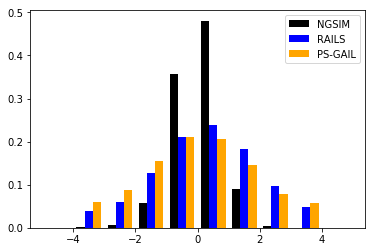

In [23]:
fig, axes = plt.subplots(nrows=1,ncols=1)

# With the expert present
colors = ['black','blue','orange']
if attributeOfInterest == 'velocity':
    binRange = (0,20)
if attributeOfInterest == 'accel':
    binRange = (-5,5)
axes.hist([expertvals,railvals,psgailvals], \
          range = binRange, normed = True, color = colors, \
          label = ['NGSIM','RAILS','PS-GAIL'])


axes.legend(prop={'size': 10})
plt.savefig(attributeOfInterest+'Distb.png')

In [ ]:
# Assumes you have run the above cell and its above rigmarole already 
# so that psgail_obs and rail_obs is defined
psgailaccels = psgail_obs[:,observation_indexes['accel']]
railaccels = rail_obs[:,observation_indexes['accel']]
expertaccels = expert['0750am-0805am']['observations'][:,observation_indexes['accel']]

fig, axes = plt.subplots(nrows=1,ncols=1)

colors = ['black','blue','red']
axes.hist([expertaccels,railaccels,psgailaccels], normed = True, color = colors, \
          label = ['NGSIM','RAILS','PS-GAIL'])
axes.legend(prop={'size': 10})
plt.savefig('Combined_AccelDistb.png')

### -----legacy: understanding traj_lab_dict structure-------------

In [ ]:
meriDict = traj_lab_dict[model_labels[0]][0][0][0]
laneInfoArray = meriDict['laneNum']
print("lane array shape = ",laneInfoArray.shape)

In [ ]:
# This should be 3, corresponding to the 3 time windows
# aka 750-805, 805-810 and 810-825
print(len(traj_lab_dict[model_labels[0]][0]))

In [ ]:
# This should be 100, corresponding to the 100 sims that we run
# within the 1st time window i.e 750-805
print(len(traj_lab_dict[model_labels[0]][0][0]))

In [ ]:
# Let's give this list a name as it is useful
listOfSims4TimeWindow1 = traj_lab_dict[model_labels[0]][0][0]

## Logic 1: All lane changes are counted in the incrementation

In [ ]:
# Comparing two timesteps all cars in one go
def calcLaneChangeRateFor1Simulation(dataArray,\
                                     n_agents = 100, max_steps = 200,\
                                    verbose = False):
    prevLaneNumsVector = np.zeros(n_agents)
    numLaneChanges = 0
    
    for step in range(max_steps):
        currentLaneNumsVector = dataArray[step,:]
        if verbose:
            # This should be (n_agents,100)
            print(currentLaneNumsVector.shape)
            
        laneChangesVector = currentLaneNumsVector - prevLaneNumsVector
        numLaneChanges += np.count_nonzero(laneChangesVector)
        
        prevLaneNumsVector = currentLaneNumsVector
    
    # Plot the lanes at the end of the 20 second simulation
    if verbose:
        print(currentLaneNumsVector)
        plt.plot(currentLaneNumsVector)
    
    return numLaneChanges/n_agents

In [ ]:
# Calculation for 1 simulation
testLaneChangeRate = calcLaneChangeRateFor1Simulation(
listOfSims4TimeWindow1[76]['laneNum'], verbose=False)
print(testLaneChangeRate)

In [ ]:
# Calculate lane change rate for every simulation and then average the result
laneChangeRateArray = np.zeros(len(listOfSims4TimeWindow1))
for i in range(len(listOfSims4TimeWindow1)):
    laneChangeRateArray[i] = \
    calcLaneChangeRateFor1Simulation(listOfSims4TimeWindow1[i]['laneNum'])
print(np.mean(laneChangeRateArray))

# Dividing by the number of timesteps
print(np.mean(laneChangeRateArray)/200)

## Logic 2: At least one lane change means increment by 1

In [ ]:
# Let's try the per car logic over one whole simulation
def calcCarWiseLaneChangeRateForOneSim(dataArray,\
                                     n_agents = 100, max_steps = 200,\
                                    verbose = False):
    
    if verbose:
        print("Number of cars = ",dataArray.shape[1])
    
    # Assume all cars have not changed lane to start with
    carHasChangedLane = np.zeros(dataArray.shape[1])
    
    
    # Iterate over all the columns of the data array
    # aka all the cars one by one
    for i in range(dataArray.shape[1]):
        # Compare all elements of that column i.e. lane id in all
        # timesteps to the top column i.e lane id in 1st timestep
        # If they are not all equal, then the car i has at least one
        # lane change so increment lane change counter by 1
        # i.e. this particular car has changed lane once in the
        # 20 second time window under consideration
        if not(
            np.all(np.isclose(dataArray[:,i],dataArray[0,i]))):
            
            carHasChangedLane[i] = 1
    
    numCarsThatHaveChangedLanes = np.sum(carHasChangedLane)
    return numCarsThatHaveChangedLanes/n_agents

In [ ]:
testLaneChangeRate = calcCarWiseLaneChangeRateForOneSim(
listOfSims4TimeWindow1[17]['laneNum'],verbose=True)
print(testLaneChangeRate)

In [ ]:
# Let's plot the lane id to see whether that on-ramp or off-ramp is
# causing problems
def plotCarLaneIDOverTime(dataArray,carNum,verbose=True):
    if verbose:
        print("Selected car number is ",carNum)
    plt.plot(dataArray[:,carNum])

In [ ]:
plotCarLaneIDOverTime(
    listOfSims4TimeWindow1[17]['laneNum'],27,verbose=True)